In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
data = pd.read_csv("../data/DMSC.csv", index_col = 0)

/home/svjack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
!wget -nc "https://codeload.github.com/weiyunchen/nlp/zip/master"

--2020-08-26 15:42:20--  https://codeload.github.com/weiyunchen/nlp/zip/master
Resolving codeload.github.com (codeload.github.com)... 13.250.162.133
Connecting to codeload.github.com (codeload.github.com)|13.250.162.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master’

master                  [   <=>              ]  75.41K   155KB/s    in 0.5s    

2020-08-26 15:42:21 (155 KB/s) - ‘master’ saved [77224]



In [5]:
!unzip master

Archive:  master
78a55b3ff658cd83cd1ae4abbe5fb475507097c3
   creating: nlp-master/
  inflating: nlp-master/faker.png    
  inflating: nlp-master/stopwords.txt  


In [3]:
with open("nlp-master/stopwords.txt", "r") as f:
    stopwords = list(map(lambda line: line.strip("\n") ,f.readlines()))
    
def cut(data, labels, stopwords):
    result = []
    new_labels = []
    for index in tqdm_notebook(range(len(data))):
        comment = clean_str(data[index])
        label = labels[index]
        seg_list = jieba.cut(comment, cut_all = False, HMM = True)
        seg_list = list(filter(lambda x: x.strip("\n") if (x not in stopwords and len(x) > 1) else None, seg_list))
        if len(seg_list) > 1:
            result.append(seg_list)
            new_labels.append(label)
    return result, new_labels

from tqdm import tqdm_notebook
import re

def clean_str(line):
    line.strip('\n')
    line = re.sub(r"[^\u4e00-\u9fff]", "", line)
    line = re.sub(
        "[0-9a-zA-Z\-\s+\.\!\/_,$%^*\(\)\+(+\"\')]+|[+——！，。？、~@#￥%……&*（）<>\[\]:：★◆【】《》;；=?？]+", "", line)
    return line.strip()


In [5]:
from tqdm.notebook import tqdm_notebook

In [7]:
from collections import defaultdict
import jieba
star_sum_dict, star_cnt_dict = defaultdict(float), defaultdict(float)
for i ,(index ,row) in tqdm_notebook(enumerate(data[["Comment", "Star"]].iterrows())):
    comment, label = clean_str(row["Comment"]), row["Star"]
    score = float(-1 if label <= 2 else 1)
    seg_list = jieba.cut(comment, cut_all = False, HMM = True)
    seg_list = list(filter(lambda x: x.strip("\n") if (x not in stopwords and len(x) > 1) else None, seg_list))
    for seg in seg_list:
        star_sum_dict[seg] += score
        star_cnt_dict[seg] += 1

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.838 seconds.
Prefix dict has been built successfully.


In [8]:
def merge_star_dict(star_sum_dict, star_cnt_dict):
    req = dict()
    for word, star_sum in star_sum_dict.items():
        req[word] = star_sum / star_cnt_dict[word]
    return req

In [9]:
score_dict = merge_star_dict(star_sum_dict, star_cnt_dict)

In [10]:
import pickle as pkl
sentiment_dict_save_path = "../data/sentiment_dict.pkl"
if os.path.exists(sentiment_dict_save_path):
    os.remove(sentiment_dict_save_path)
with open(sentiment_dict_save_path, "wb") as f:
    pkl.dump({
        "star_sum_dict": star_sum_dict,
        "star_cnt_dict": star_cnt_dict, 
        "score_dict": score_dict
    }, f)

In [11]:
def trans_dict_to_series(d):
    return pd.Series(list(d.values()),index=d.keys())

In [12]:
star_sum_s = trans_dict_to_series(star_sum_dict)
star_cnt_s = trans_dict_to_series(star_cnt_dict)
star_df = pd.concat([star_cnt_s, star_sum_s], axis = 1)
star_df.columns = ["cnt", "score_sum"]
star_df["score_mean"] = star_df["score_sum"] / star_df["cnt"]

In [13]:
def filter_star_df(star_df):
    req = star_df[star_df["score_mean"] > -1.0]
    req = req[req["score_mean"] < 1.0]
    req = req[req["score_mean"] != 0.0]
    return req

In [14]:
req_df = filter_star_df(star_df)

<AxesSubplot:xlabel='score_mean'>

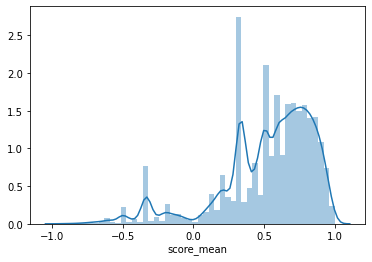

In [15]:
import seaborn as sns
sns.distplot(req_df["score_mean"])

In [16]:
score_df_path = "../data/douban_word_senti_dict.csv"
if os.path.exists(score_df_path):
    os.remove(score_df_path)
req_df.to_csv(score_df_path, index = True)